In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ete3
from ete3 import PhyloTree
from Bio import SeqIO

4.341838297296173


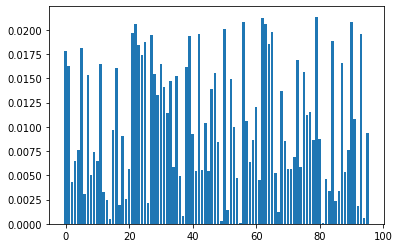

In [2]:
a = np.random.random(96)
a = a / a.sum()
print(scipy.stats.entropy(a))
plt.bar(np.arange(96), a);

4.564348191467836


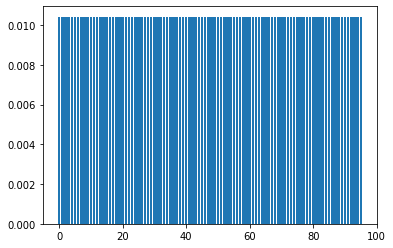

In [47]:
b = np.ones(96)
b = b / b.sum()
print(scipy.stats.entropy(b))
plt.bar(np.arange(96), b);

3.523707089188763


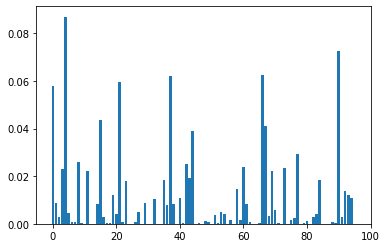

In [48]:
c = np.random.chisquare(.5, 96)
c = c / c.sum()
print(scipy.stats.entropy(c))
plt.bar(np.arange(96), c);

3.828900502490261


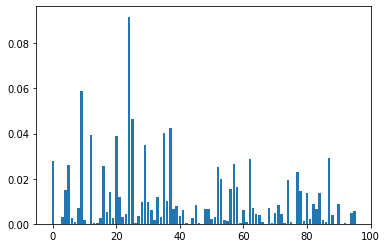

In [49]:
d = np.random.gamma(.5, 10, 96)
d = d / d.sum()
print(scipy.stats.entropy(d))
plt.bar(np.arange(96), d);

2.537365977619637


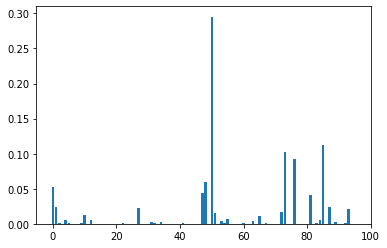

In [52]:
d = np.random.gamma(.1, 100, 96)
d = d / d.sum()
print(scipy.stats.entropy(d))
plt.bar(np.arange(96), d);

## Compare uniformity metrics

In [57]:
n = 200
d = 96
mutspecs = []
for _ in range(n):
    a = np.random.random(d)
    a = a / a.sum()
    mutspecs.append(a)
    
for _ in range(n):
    a = np.random.chisquare(.5, d)
    a = a / a.sum()
    mutspecs.append(a)

for _ in range(n):
    a = np.random.gamma(.5, 10, d)
    a = a / a.sum()
    mutspecs.append(a)

for _ in range(n):
    a = np.random.gamma(.1, 100, d)
    a = a / a.sum()
    mutspecs.append(a)

In [68]:
entr, cossim, custom = [], [], []
for ms in mutspecs:
    assert np.isclose(scipy.linalg.norm(ms, 1), 1), f"{scipy.linalg.norm(ms, 1)} != 1"
    entr.append(scipy.stats.entropy(ms))
    _norm = scipy.linalg.norm(ms)
    b = np.ones(d) / d
    _cossim = 1 - scipy.spatial.distance.cosine(ms, b)
    assert np.isclose(_cossim, 1 / _norm / np.sqrt(d)), f"{_cossim} != {1 / _norm / np.sqrt(d)}"
    cossim.append(_cossim)
    custom.append(scipy.linalg.norm(ms - 1 / d, 1) / d)

In [69]:
scipy.stats.pearsonr(custom, cossim)

(-0.9878434904278504, 0.0)

In [70]:
np.corrcoef([entr, cossim, custom])

array([[ 1.        ,  0.96569195, -0.97257305],
       [ 0.96569195,  1.        , -0.98784349],
       [-0.97257305, -0.98784349,  1.        ]])

## Compare normalized and non-normalized mutspec similarity

In [3]:
n = 200
d = 96
mutspecs1 = []
for _ in range(n):
    a = np.random.random(d)
    a = a / a.sum()
    mutspecs1.append(a)
    
for _ in range(n):
    a = np.random.chisquare(.5, d)
    a = a / a.sum()
    mutspecs1.append(a)

for _ in range(n):
    a = np.random.gamma(.5, 10, d)
    a = a / a.sum()
    mutspecs1.append(a)

for _ in range(n):
    a = np.random.gamma(.1, 100, d)
    a = a / a.sum()
    mutspecs1.append(a)

mutspecs2 = []
for _ in range(n):
    a = np.random.random(d)
    a = a / a.sum()
    mutspecs2.append(a)
    
for _ in range(n):
    a = np.random.chisquare(.5, d)
    a = a / a.sum()
    mutspecs2.append(a)

for _ in range(n):
    a = np.random.gamma(.5, 10, d)
    a = a / a.sum()
    mutspecs2.append(a)

for _ in range(n):
    a = np.random.gamma(.1, 100, d)
    a = a / a.sum()
    mutspecs2.append(a)

<BarContainer object of 96 artists>

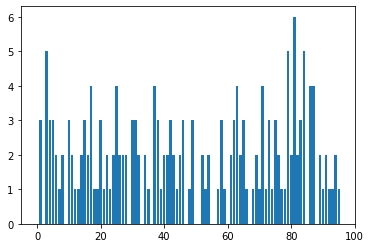

In [59]:
plt.bar(np.arange(d), np.random.binomial(100, .02, d))

In [67]:
sims = []
sim_ns = []

for _ in range(1000):
    ms1 = np.random.gamma(0.8, 50, d)
    ms2 = np.random.gamma(0.8, 50, d)
    norma = np.random.binomial(100, .02, d) + 1
    ms1n = ms1 / norma
    ms2n = ms2 / norma

    sim = scipy.spatial.distance.cosine(ms1, ms2)
    sim_n = scipy.spatial.distance.cosine(ms1n, ms2n)

    sims.append(sim)
    sim_ns.append(sim_n)

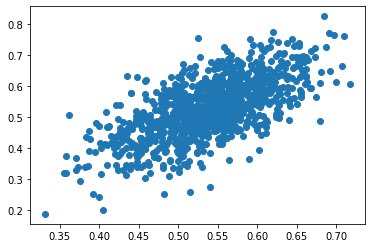

In [68]:
plt.scatter(sims, sim_ns)

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mutspec.constants import possible_sbs192
from mutspec.annotation import rev_comp, transcriptor

kk_lbls = "A>C A>G A>T C>T G>C G>T".split()
cosmic_lbls = "C>A C>G C>T T>A T>C T>G".split()

df = pd.DataFrame({"sbs": possible_sbs192})
df["sbs_base"] = df["sbs"].str.slice(2, 5)
df["sbs_base_revcomp"] = df["sbs_base"].str.translate(transcriptor)
df["sbs_revcomp"] = df["sbs"].apply(rev_comp)
df["is_cosmic"] = df["sbs_base"].isin(cosmic_lbls)
df["is_kk"] = df["sbs_base"].isin(kk_lbls)
df["sbs_base_for_sorting_kp"] = df.apply(lambda x: x.sbs_base + "1" if x.is_cosmic else x.sbs_base_revcomp + "2", axis=1)
df["sbs_for_ordering_kk"] = df.apply(lambda x: x.sbs if x.is_kk else x.sbs_revcomp, axis=1)
df["sbs_for_ordering_kp"] = df.apply(lambda x: x.sbs if x.is_cosmic else x.sbs_revcomp, axis=1)

ordered_sbs192_kp = list(df.sort_values(["sbs_base_for_sorting_kp", "sbs_for_ordering_kp"]).sbs.values)
ordered_sbs192_kk = list(df.sort_values(["sbs_base", "sbs_for_ordering_kk"]).sbs.values)
df

,sbs,sbs_base,sbs_base_revcomp,sbs_revcomp,is_cosmic,is_kk,sbs_base_for_sorting_kp,sbs_for_ordering_kk,sbs_for_ordering_kp
0,A[A>C]A,A>C,T>G,T[T>G]T,False,True,T>G2,A[A>C]A,T[T>G]T
1,A[A>C]C,A>C,T>G,G[T>G]T,False,True,T>G2,A[A>C]C,G[T>G]T
2,A[A>C]G,A>C,T>G,C[T>G]T,False,True,T>G2,A[A>C]G,C[T>G]T
3,A[A>C]T,A>C,T>G,A[T>G]T,False,True,T>G2,A[A>C]T,A[T>G]T
4,C[A>C]A,A>C,T>G,T[T>G]G,False,True,T>G2,C[A>C]A,T[T>G]G
...,...,...,...,...,...,...,...,...,...
187,G[T>G]T,T>G,A>C,A[A>C]C,True,False,T>G1,A[A>C]C,G[T>G]T
188,T[T>G]A,T>G,A>C,T[A>C]A,True,False,T>G1,T[A>C]A,T[T>G]A
189,T[T>G]C,T>G,A>C,G[A>C]A,True,False,T>G1,G[A>C]A,T[T>G]C
190,T[T>G]G,T>G,A>C,C[A>C]A,True,False,T>G1,C[A>C]A,T[T>G]G


In [2]:
for rec in SeqIO.parse("../tmp/evolve/alignment_checked.fasta", format="fasta"):
    break

In [4]:
seq = str(rec.seq)

In [5]:
from collections import Counter

In [6]:
Counter(seq)

Counter({'A': 201, 'T': 182, 'G': 74, 'C': 221})